In [52]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import healpy as hp

## PI0 GAMMA-RAY EMISSION

CR nuclei with interstellar gas:
\begin{equation}
\epsilon_E (E_\gamma,\vec{r}) = 4\pi n_H(\vec{r}) \int dE\, \Phi_H \frac{d\sigma_{p-p}}{dE_\gamma}
\end{equation}

In [53]:
file = 'HandsOn/BaseModel_pi0_HI.fits'
hdu = fits.open(file)
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                    4 / width of table in bytes                        
NAXIS2  =               196608 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    1 / number of fields in each row                   
TTYPE1  = 'TFLOAT  '           / label for field   1                            
TFORM1  = '1E      '           / data format of field: 4-byte REAL              
TUNIT1  = 'GeV^-1 m^-2 s^-1 sr^-1' / physical unit of field                     
EXTNAME = 'xtension'           / name of this binary table extension            
PIXTYPE = 'HEALPIX '        

In [54]:
HI = hp.read_map(file)
H2 = hp.read_map('HandsOn/BaseModel_pi0_H2.fits')

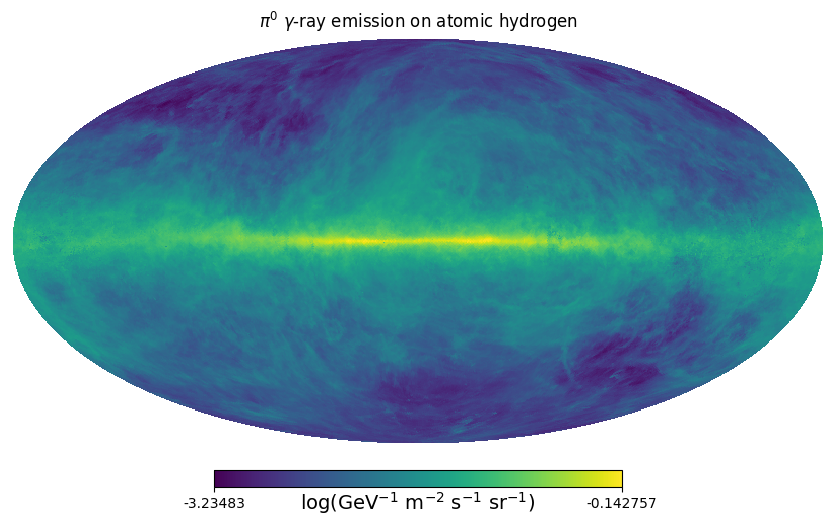

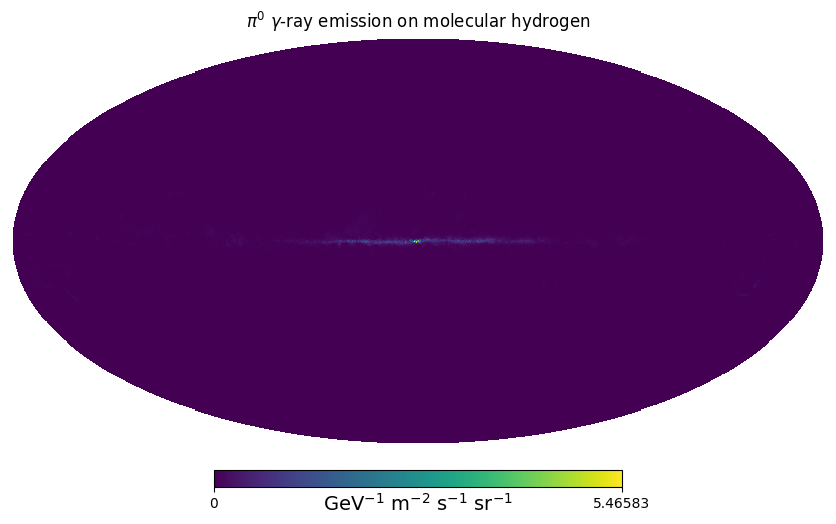

In [56]:
hp.mollview(np.log10(HI),title=r'$\pi^0$ $\gamma$-ray emission on atomic hydrogen', unit= r'log(GeV$^{-1}$ m$^{-2}$ s$^{-1}$ sr$^{-1}$)')

hp.mollview(H2,title=r'$\pi^0$ $\gamma$-ray emission on molecular hydrogen',unit = r'GeV$^{-1}$ m$^{-2}$ s$^{-1}$ sr$^{-1}$')

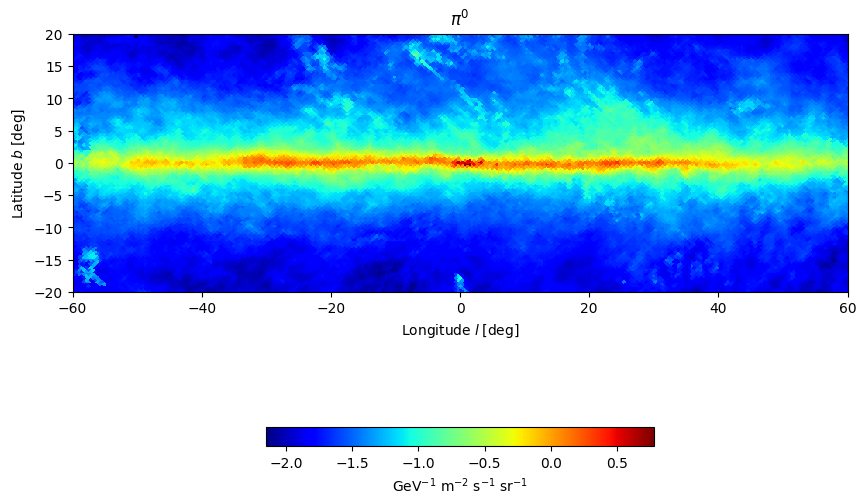

In [57]:
from pyhermes import *
from pyhermes.units import TeV, deg, kpc, pc, radian2degree

pi0 = np.log10(HI + H2)
nside = hdu[1].header['NSIDE']

fig = plt.figure(figsize=(10,7))

l = 60*deg
b = 20*deg
mask_lon_in_deg = [float(radian2degree(a)) for a in [-l, l]]
mask_lat_in_deg = [float(radian2degree(a)) for a in [-b, b]]

projector = hp.projector.CartesianProj(flipconv="geo")
projector.set_proj_plane_info(xsize=1000, ysize=None,
                              lonra=mask_lon_in_deg,
                              latra=mask_lat_in_deg
                              )
projected_map = projector.projmap(
    pi0,
    lambda x, y, z: hp.pixelfunc.vec2pix(nside, x, y, z, nest=False)  
)
w = ~(np.isnan(projected_map) | np.isinf(projected_map) | hp.pixelfunc.mask_bad(projected_map, badval=UNSEEN))
#projected_map[w] *= base_units
vmin = projected_map[w].min()
vmax = projected_map[w].max()
img = plt.imshow(projected_map, extent=mask_lon_in_deg + mask_lat_in_deg, cmap='jet', interpolation="nearest", origin="lower",
            vmin=vmin, vmax=vmax)

plt.title(r'$\pi^0$')
plt.xlabel(r'${\rm Longitude} \; l \; {\rm [deg]}$')
plt.ylabel(r'${\rm Latitude} \; b \; {\rm [deg]}$')

cb = fig.colorbar(img, orientation='horizontal', shrink=.5, pad=0.25)
cb.ax.xaxis.set_label_text('GeV$^{-1}$ m$^{-2}$ s$^{-1}$ sr$^{-1}$')
cb.solids.set_edgecolor("face")

# BREMSSTRAHLUNG

CR leptons with interstellar gas:
\begin{equation}
\epsilon_E (E_\gamma,\vec{r}) = 4\pi n_H(\vec{r}) \int dE\, \Phi_{lep} \frac{d\sigma_{br}}{dE_\gamma}(H,E_\gamma,E)
\end{equation}

In [59]:
nside = 128
npix = 12*nside**2
nmaps = 5

J_to_GeV = 1/1.6e-10


brems = np.zeros((nmaps,npix))
E = np.zeros(nmaps)

filename = 'HandsOn/BaseModel_brems.fits'
hdu = fits.open(filename)

for i in range(nmaps):
    E[i] = hdu[i+1].header['energy']*J_to_GeV
    brems[i,:] = hdu[i+1].data

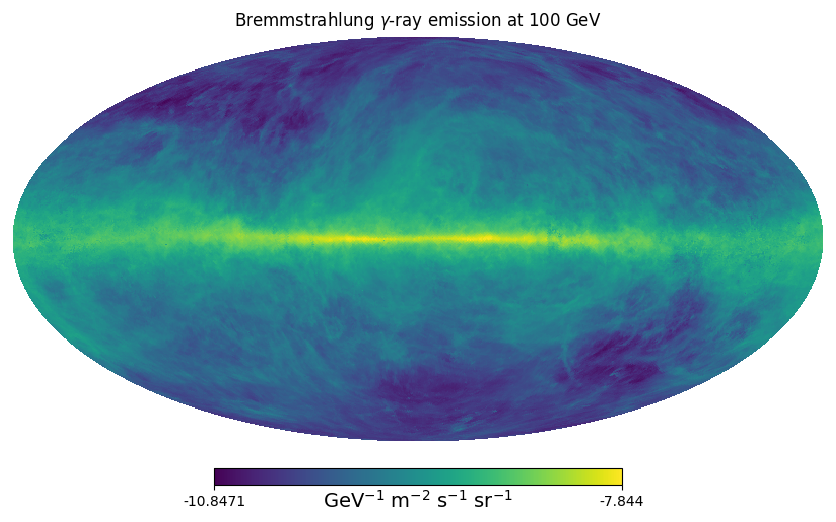

In [61]:
hp.mollview(np.log10(brems[-1]),title=r'Bremmstrahlung $\gamma$-ray emission at 100 GeV',unit = 'GeV$^{-1}$ m$^{-2}$ s$^{-1}$ sr$^{-1}$' )

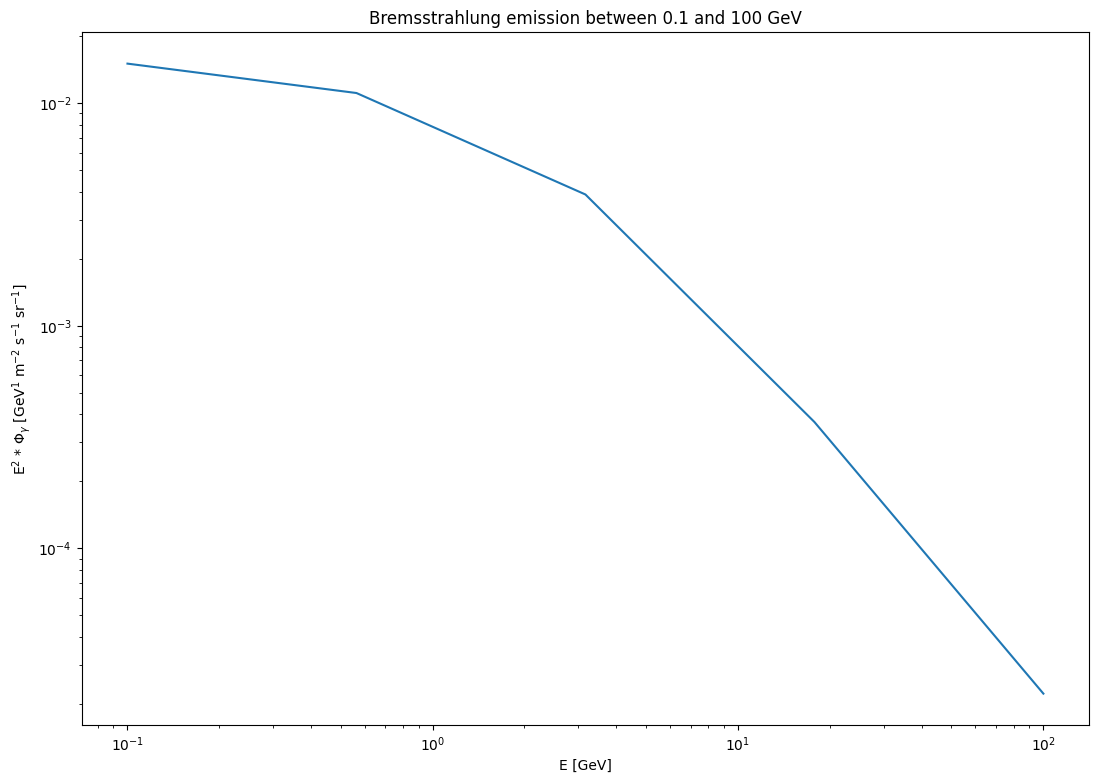

In [62]:
vec1 = hp.ang2vec(15,5,lonlat=True)
vec2 = hp.ang2vec(125,5,lonlat=True)
vec3 = hp.ang2vec(15,-5,lonlat=True)
vec4 = hp.ang2vec(125,-5,lonlat=True)

box = np.array([vec1,vec2,vec4,vec3])
ipix = hp.query_polygon(nside,box)

brems_spec = np.nanmean(brems[:,ipix],axis=1)

fig, ax = plt.subplots( figsize=(13,9))

ax.loglog(E,brems_spec*E**2)
ax.set_title('Bremsstrahlung emission between 0.1 and 100 GeV')
ax.set_xlabel('E [GeV]')
ax.set_ylabel(r'E$^2$ * $\Phi_\gamma$ [GeV$^{1}$ m$^{-2}$ s$^{-1}$ sr$^{-1}$]')
plt.show()
plt.close()

# EXERCISE

Compute the pi0 emission spectrum using Kamae ( Kamae06Gamma ) and Kelner&Aharonian ( KelnerAharonianGamma ) cross sections and compare them from 1 to 1000 GeV

# COMPARISON WITH FERMI DATA FOR LHAASO REGION

In [32]:
data = '../../DRAGON2-Beta_version/output/datasets/fermi_data_lhaaso_region.txt'

E_fermi, f_fermi, up_err = np.loadtxt(data,usecols=(0, 1, 2), unpack=True)
err = up_err - f_fermi

In [47]:
nside = 64
npix = 12*nside**2
nmaps = 11

H2= np.zeros((nmaps,npix))
HI = np.zeros((nmaps,npix))
E = np.zeros(nmaps)

filename = 'HandsOn/BaseModel_pi0spec_HI.fits'
hdu_HI = fits.open(filename)

filename = 'HandsOn/BaseModel_pi0spec_H2.fits'
hdu_H2 = fits.open(filename)

for i in range(nmaps):
    E[i] = hdu_HI[i+1].header['energy']/1.6e-10
    HI[i,:] = hdu_HI[i+1].data
    H2[i,:] = hdu_H2[i+1].data

m2_to_cm2 = 1e4
pi0 = (HI + H2)/m2_to_cm2# convert from m^-2 to cm^-2

In [48]:
vec1 = hp.ang2vec(15,5,lonlat=True)
vec2 = hp.ang2vec(125,5,lonlat=True)
vec3 = hp.ang2vec(15,-5,lonlat=True)
vec4 = hp.ang2vec(125,-5,lonlat=True)

box = np.array([vec1,vec2,vec4,vec3])
ipix = hp.query_polygon(nside,box)

pi0_spec = np.nanmean(pi0[:,ipix],axis=1)

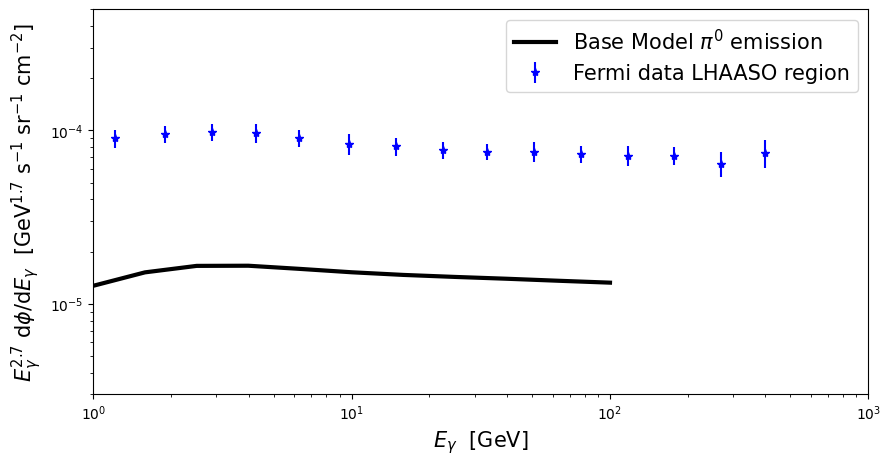

In [50]:
plt.figure(figsize=(10,5))
plt.loglog(E, pi0_spec*E**2.7,'k',linewidth=3,label = r'Base Model $\pi^0$ emission')
plt.errorbar(E_fermi*1e3,f_fermi*1e3**1.7,yerr=err*1e3**1.7,marker='*',color='b',linestyle=' ',label='Fermi data LHAASO region')
plt.legend(fontsize=15)
plt.ylabel(r'$E^{2.7}_\gamma$ d$\phi$/d$E_\gamma$  [GeV$^{1.7}$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$]',fontsize=15)
plt.xlabel(r'$E_\gamma$  [GeV]',fontsize=15)
plt.ylim(3e-6,5e-4)
plt.xlim(1e0,1e3)
plt.show()

# IC EMISSION

CR leptons with ISRF:
\begin{equation}
\epsilon_E (E_\gamma,\vec{r}) = 4\pi \int dE_{ph} \frac{dn_{ph}}{dE_{ph}} (E_{ph},\vec{r}) \int dE_e \frac{d\sigma_{IC}}{dE_\gamma}(E_e,E_{ph},E_\gamma) \Phi_{lep}(E_e,\vec{r})
\end{equation}

In [65]:
file = 'HandsOn/3D_run_IC.fits'
hdu = fits.open(file)
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                    4 / width of table in bytes                        
NAXIS2  =                49152 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    1 / number of fields in each row                   
TTYPE1  = 'TFLOAT  '           / label for field   1                            
TFORM1  = '1E      '           / data format of field: 4-byte REAL              
TUNIT1  = 'GeV^-1 m^-2 s^-1 sr^-1' / physical unit of field                     
EXTNAME = 'xtension'           / name of this binary table extension            
PIXTYPE = 'HEALPIX '        

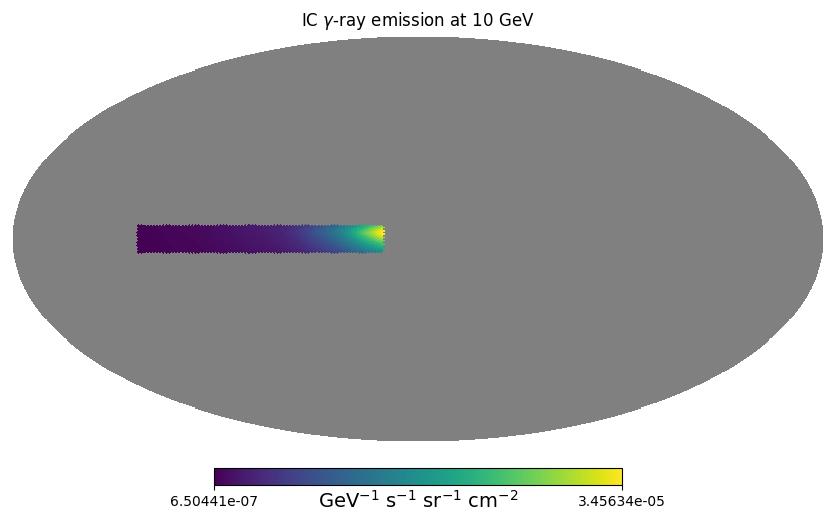

In [66]:
nside = hdu[1].header['nside']

IC = np.zeros(12*nside**2)
IC[:] = hdu[1].data

hp.mollview(IC,title=r'IC $\gamma$-ray emission at 10 GeV', unit = r'GeV$^{-1}$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$')

# SYNCHROTRON

CR leptons in magnetic fields:

\begin{equation}
\epsilon_\nu (\nu,\vec{r}) = \frac{4\pi}{c} \int dE \, \Phi_{lep}(E,\vec{r}) j_\nu (E,\vec{r},\nu)
\end{equation}
with
\begin{equation}
j_\nu = \frac{\sqrt{3}q^3 B}{8 \pi^2\epsilon_0 m_e} F(\frac{\nu}{\nu_c})
\end{equation}

In [23]:
file = 'HandsOn/BaseModel_Synchro.fits'
hdu = fits.open(file)
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                    4 / width of table in bytes                        
NAXIS2  =                49152 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    1 / number of fields in each row                   
TTYPE1  = 'TFLOAT  '           / label for field   1                            
TFORM1  = '1E      '           / data format of field: 4-byte REAL              
TUNIT1  = 'SI Base Units'      / physical unit of field                         
EXTNAME = 'xtension'           / name of this binary table extension            
PIXTYPE = 'HEALPIX '        

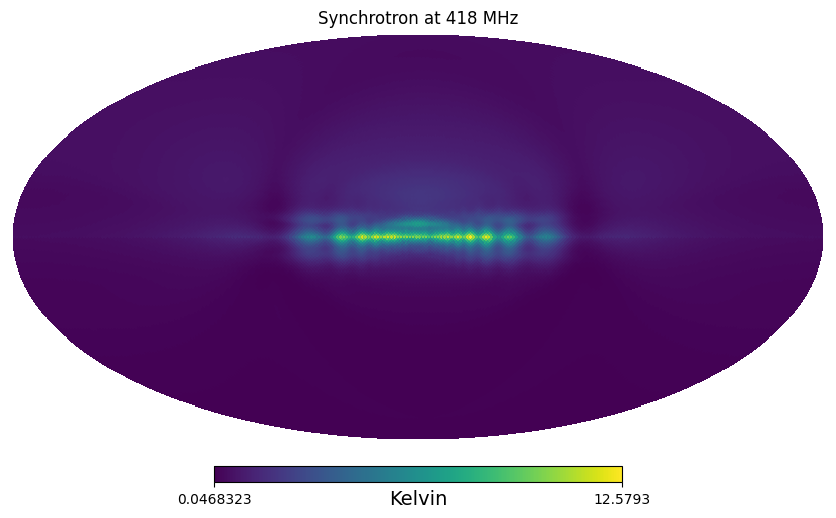

In [63]:
sync = hp.read_map('HandsOn/BaseModel_Synchro.fits')

hp.mollview(sync,title=r'Synchrotron at 418 MHz',unit = 'Kelvin')

# EXERCISE

Compare synchrotron emission with Pshirkov and Farrar magnetic fields

## EXERCISE: NEUTRINOS

Calculate the neutrino emission map by replacing 'Gamma' by 'Neutrino' to the pi0 cross section